# Notebook for testing out methods with limiters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import animation
from IPython.display import HTML
from numpy.linalg import inv, det
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy.linalg as LA

In [50]:
# define grids
nx = 200
nt = 1000
nlayers = 2
# moved boundaries away as there was some nasty feedback occuring here
xmin = -5.
xmax = 15.
alpha = 0.9
beta = 0.
gamma = 1 / alpha**2

class U:
    def __init__(self, nlayers, nx, nt, xmin, xmax, rho, alpha, beta, gamma, periodic=True):
        self.nlayers = nlayers
        self.nx = nx
        self.nt = nt
        
        self.U = np.zeros((2, nlayers, nx, nt+1))
        
        self.x = np.linspace(xmin, xmax, num=nx-4, endpoint=False)
        self.rho = rho
        
        self.dx = self.x[1] - self.x[0]
        self.dt = 0.1 * self.dx
        
        # metric stuff
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma # gamma down
        self.gamma_up = 1/gamma
        
        self.periodic = periodic
        
    def D(self,indices):
        return self.U[(0,) + tuple(indices)]
    
    def Sx(self,indices):
        return self.U[(1,) + tuple(indices)]
        
    def initial_data(self, D0=None, Sx0=None):
        """
        Set the initial data
        """
        
        if D0 is not None:
            self.U[0,:,:,0] = D0
            
        if Sx0 is not None:
            self.U[1,:,:,0] = Sx0
            
        # enforce bcs
        self.bcs(0)
        
    def Uj(self, layer, t):
        return self.U[:,layer,:,t]
    
    def bcs(self, t):
        
        if self.periodic:
            self.U[:,:,:2,t] = self.U[:,:,-4:-2,t]
            self.U[:,:,-2:,t] = self.U[:,:,2:4,t]
        
        else: # outflow
            self.U[:,:,:2,t] = self.U[:,:,np.newaxis,2,t]
            self.U[:,:,-2:,t] = self.U[:,:,np.newaxis,-3,t]

rho = np.ones(nlayers)

U = U(nlayers, nx, nt, xmin, xmax, rho, alpha, beta, gamma, periodic=True)

# Start off with an initial water hill
D0 = np.zeros_like(U.U[0,:,:,0])
D0[0,2:-2] = 1 + 0.2 * np.exp(-(U.x-2)**2*2) 
D0[1,2:-2] = 0.8 + 0.1 * np.exp(-(U.x-7)**2*2)

U.initial_data(D0=D0)

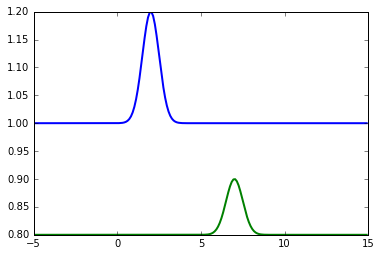

In [51]:
plt.plot(U.x,U.U[0,0,2:-2,0],U.x,U.U[0,1,2:-2,0], lw=2)
plt.show()

In [52]:
def evolve(n):
    
    for j in range(nlayers):
        
        # to simplify indexing to 2 indices rather than 4
        qn = U.U[:,j,:,n]
        
        # find slopes 
        S_upwind = (qn[:,2:] - qn[:,1:-1]) / U.dx
        S_downwind = (qn[:,1:-1] - qn[:,:-2]) / U.dx
        S_av = 0.5 * (S_upwind + S_downwind)
        
        # ratio 
        r = np.ones_like(S_av) * 1.e6
        # mask to stop divide by zero
        r[S_downwind > 1.e-10] = S_upwind[S_downwind > 1.e-10] / S_downwind[S_downwind > 1.e-10]

        # MC
        #phi = np.maximum(0.0, np.minimum(2.*r/(1.+r), 2./(1.+r)))
        # superbee
        phi = np.maximum(0.0, np.minimum(1,2.*r), np.minimum(2., r))
        
        S = phi * S_av
        
        qp = qn[:,1:-1] + S * 0.5 * U.dx # defined from 1+1/2 to -2+1/2
        qm = qn[:,1:-1] - S * 0.5 * U.dx # defined from 1-1/2 to -2-1/2
        
        fp = np.zeros_like(qp)
        fm = np.zeros_like(qm)
        
        W = np.sqrt(qp[1,:]**2 * U.gamma_up / qp[0,:]**2 + 1)
        u = qp[1,:] / (qp[0,:] * W) # u_down
            
        qx = u * U.gamma_up - U.beta/U.alpha
        
        fp[0,:] = qp[0,:] * qx
        fp[1,:] = qp[1,:] * qx + 0.5 * qp[0,:]**2 / W**2
        
        W = np.sqrt(qm[1,:]**2 * U.gamma_up / qm[0,:]**2 + 1)
        u = qm[1,:] / (qm[0,:] * W) # u_down
            
        qx = u * U.gamma_up - U.beta/U.alpha
        
        fm[0,:] = qm[0,:] * qx
        fm[1,:] = qm[1,:] * qx + 0.5 * qm[0,:]**2 / W**2
        
        # Lax-Friedrichs flux 
        # at each boundary, we have a left and right state 
        # NOTE: This method requires two ghost cells on either side! 
        qL = qp[:,:-1] # defined from 1+1/2 to -2-1/2, projected from left side of interface
        qR = qm[:,1:] # 1+1/2 to -2-1/2, projected from right of interface
        fL = fp[:,:-1]
        fR = fm[:,1:]
        
        alp = 1. # alpha
        f_minus_half = 0.5 * (fL[:,:-1] + fR[:,:-1] + alp * (qL[:,:-1] - qR[:,:-1])) # 1+1/2 to -3-1/2
        f_plus_half = 0.5 * (fL[:,1:] + fR[:,1:] + alp * (qL[:,1:] - qR[:,1:])) # 2+1/2 to -2-1/2
        
        U.U[:,j,2:-2,n+1] = qn[:, 2:-2] - U.dt/U.dx * U.alpha * (f_plus_half - f_minus_half) # 2 to -3
        
        
    # do boundaries
    U.bcs(n+1)   
   

In [53]:
for i in range(nt):
    evolve(i)

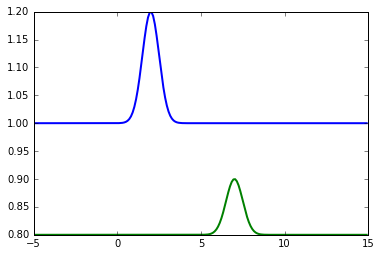

In [54]:
plt.plot(U.x,U.U[0, 0, 2:-2, 0],U.x,U.U[0, 1, 2:-2, 0], lw=2)
plt.show()

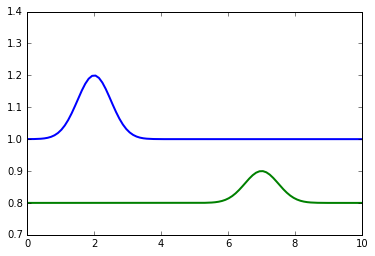

In [55]:
fig = plt.figure()
ax = plt.axes(xlim=(0,10), ylim=(0.7,1.4))
line = ax.plot([],[], lw=2)[0]
line2 = ax.plot([],[], lw=2)[0]

def animate(i):
    line.set_data(U.x, U.U[0, 0, 2:-2,i*10])
    line2.set_data(U.x, U.U[0, 1, 2:-2,i*10])

anim = animation.FuncAnimation(fig, animate, frames=100, interval=60)#, init_func=init)

In [56]:
HTML(anim.to_html5_video())

## GR 3d

In [2]:
# define grids
nx = 100
ny = 100
nt = 200
nlayers = 2
xmin = -5.
xmax = 15.
ymin = -5.
ymax = 15.
alpha = 1.0
beta = [0., 0.]
gamma = 1 / alpha**2 * np.eye(2)

class U:
    def __init__(self, nlayers, nx, ny, nt, xmin, xmax, ymin, ymax, rho, alpha, beta, gamma, periodic=True):
        self.nlayers = nlayers
        self.nx = nx
        self.ny = ny
        self.nt = nt
        
        self.U = np.zeros((3, nlayers, nx, ny, nt+1))
        
        self.x = np.linspace(xmin, xmax, num=nx-4, endpoint=False)
        self.y = np.linspace(ymin, ymax, num=ny-4, endpoint=False)
        self.rho = rho
        
        self.dx = self.x[1] - self.x[0]
        self.dy = self.y[1] - self.y[0]
        self.dt = 0.1 * min(self.dx, self.dy)
        
        # metric stuff
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma # gamma down
        self.gamma_up = inv(gamma)
        
        self.periodic = periodic
        
    def D(self,indices):
        return self.U[(0,) + tuple(indices)]
    
    def Sx(self,indices):
        return self.U[(1,) + tuple(indices)]
    
    def Sy(self,indices):
        return self.U[(2,) + tuple(indices)]
        
    def initial_data(self, D0=None, Sx0=None, Sy0=None, Q=None):
        """
        Set the initial data
        """
        
        if D0 is not None:
            self.U[0,:,:,:,0] = D0
            
        if Sx0 is not None:
            self.U[1,:,:,:,0] = Sx0
            
        if Sy0 is not None:
            self.U[2,:,:,:,0] = Sy0
            
        if Q is not None:
            self.Q = Q
            
        # enforce bcs
        self.bcs(0)
        
    def Uj(self, layer, t):
        return self.U[:,layer,:,:,t]
    
    def bcs(self, t):
        
        if self.periodic:
            self.U[:,:,:2,:,t] = self.U[:,:,-4:-2,:,t]
            self.U[:,:,:,:2,t] = self.U[:,:,:,-4:-2,t]
            self.U[:,:,-2:,:,t] = self.U[:,:,2:4,:,t]
            self.U[:,:,:,-2:,t] = self.U[:,:,:,2:4,t]
            
        else: #outflow
            self.U[:,:,:2,:,t] = self.U[:,:,np.newaxis,2,:,t]
            self.U[:,:,:,:2,t] = self.U[:,:,:,np.newaxis,2,t]
            self.U[:,:,-2:,:,t] = self.U[:,:,np.newaxis,-3,:,t]
            self.U[:,:,:,-2:,t] = self.U[:,:,:,np.newaxis,-3,t]
            
rho = np.ones(nlayers)
# going to try setting the top fluid to be heavier 
#rho[0] = 1.5

In [3]:
U = U(nlayers, nx, ny, nt, xmin, xmax, ymin, ymax, rho, alpha, beta, gamma, periodic=False)

# Start off with an initial water hill
D0 = np.zeros_like(U.U[0,:,:,:,0])
D0[0,2:-2,2:-2] = 1 + 0.4 * np.exp(-((U.x[:,np.newaxis]-2)**2 + (U.y[np.newaxis,:]-2)**2)*2)
D0[1,2:-2,2:-2] = 0.8 + 0.2 * np.exp(-((U.x[:,np.newaxis]-7)**2 + (U.y[np.newaxis,:]-7)**2)*2)

# heating rate - flux of material from lower to upper layer. Set Q of top layer as 0.
Q = np.zeros((nlayers, nx, ny))
Q[:,2:-2,2:-2] = 0.2 * np.exp(-((U.x[np.newaxis,:,np.newaxis]-5)**2 + (U.y[np.newaxis,np.newaxis,:]-5)**2)*2)
Q[0,:,:] = -Q[0,:,:]

U.initial_data(D0=D0, Q=Q)

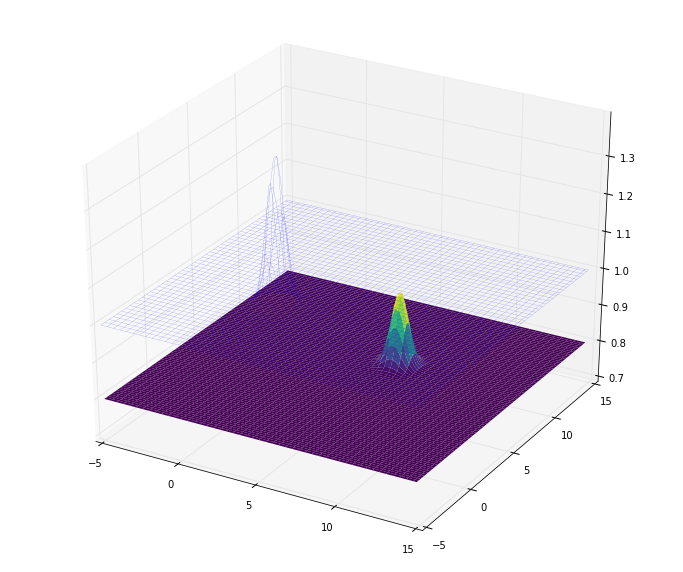

In [4]:
X, Y = np.meshgrid(U.x,U.y)

fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')

ax.set_xlim(-5,15)
ax.set_ylim(-5,15)
ax.set_zlim(0.7,1.4)

ax.plot_surface(X,Y,U.U[0,1,2:-2,2:-2,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

ax.plot_wireframe(X,Y,U.U[0,0,2:-2,2:-2,0], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)

#ax.view_init(80)

#plt.plot(x,h[0,1:-1,0],x,h[1,1:-1,0], lw=2)
plt.show()

In [5]:
# evolution using second-order Lax-Wendroff
# note: have assumed metric is constant so can move outside of derivatives
def evolve(U, n):
    
    for j in range(nlayers):
        
        # to simplify indexing to 3 indices rather than 5
        qn = U.U[:,j,:,:,n]
        
        # x-direction 
        
        # find slopes 
        S_upwind = (qn[:,2:,2:-2] - qn[:,1:-1,2:-2]) / U.dx
        S_downwind = (qn[:,1:-1,2:-2] - qn[:,:-2,2:-2]) / U.dx
        S_av = 0.5 * (S_upwind + S_downwind)
        
        # ratio 
        r = np.ones_like(S_av) * 1.e6
        # mask to stop divide by zero
        r[S_downwind > 1.e-10] = S_upwind[S_downwind > 1.e-10] / S_downwind[S_downwind > 1.e-10]

        # MC
        #phi = np.maximum(0.0, np.minimum(2.*r/(1.+r), 2./(1.+r)))
        # superbee
        phi = np.maximum(0.0, np.minimum(1,2.*r), np.minimum(2., r))
        
        S = phi * S_av
        
        qp = qn[:,1:-1,2:-2] + S * 0.5 * U.dx
        qm = qn[:,1:-1,2:-2] - S * 0.5 * U.dx
        
        fp = np.zeros_like(qp)
        fm = np.zeros_like(qm)
        
        W = np.sqrt((qp[1,:,:]**2 * U.gamma_up[0,0] + 2 * qp[1,:,:] * qp[2,:,:] * U.gamma_up[0,1] + 
                        qp[2,:,:]**2 * U.gamma_up[1,1]) / qp[0,:,:]**2 + 1)
        u = qp[1,:,:] / (qp[0,:,:] * W) # u_down
        v = qp[2,:,:] / (qp[0,:,:] * W) # u_down
            
        qx = u * U.gamma_up[0,0] + v * U.gamma_up[0,1] - U.beta[0]/U.alpha
        #qy = v * U.gamma_up[1,1] + u * U.gamma_up[0,1] - U.beta[1]/U.alpha
        
        fp[0,:,:] = qp[0,:,:] * qx
        fp[1,:,:] = qp[1,:,:] * qx + 0.5 * qp[0,:,:]**2 / W**2
        fp[2,:,:] = qp[2,:,:] * qx 
        
        W = np.sqrt((qm[1,:,:]**2 * U.gamma_up[0,0] + 2 * qm[1,:,:] * qm[2,:,:] * U.gamma_up[0,1] + 
                        qm[2,:,:]**2 * U.gamma_up[1,1]) / qm[0,:,:]**2 + 1)
        u = qm[1,:,:] / (qm[0,:,:] * W) # u_down
        v = qm[2,:,:] / (qm[0,:,:] * W) # u_down
            
        qx = u * U.gamma_up[0,0] + v * U.gamma_up[0,1] - U.beta[0]/U.alpha
        #qy = v * U.gamma_up[1,1] + u * U.gamma_up[0,1] - U.beta[1]/U.alpha
        
        fm[0,:,:] = qm[0,:,:] * qx
        fm[1,:,:] = qm[1,:,:] * qx + 0.5 * qm[0,:,:]**2 / W**2
        fm[2,:,:] = qm[2,:,:] * qx 
        
        # Lax-Friedrichs flux 
        # at each boundary, we have a left and right state 
        # NOTE: This method requires two ghost cells on either side! 
        #qL = qp[:,:-1,:]
        #qR = qm[:,1:,:]
        #fL = fp[:,:-1,:]
        #fR = fm[:,1:,:]
        
        alp = 1. # alpha
        #fx_minus_half = 0.5 * (fL[:,:-1,:] + fR[:,:-1,:] + alp * (qL[:,:-1,:] - qR[:,:-1,:]))
        #fx_plus_half = 0.5 * (fL[:,1:,:] + fR[:,1:,:] + alp * (qL[:,1:,:] - qR[:,1:,:]))
        
        fx_minus_half = 0.5 * (fp[:,:-2,:] + fm[:,1:-1,:] + alp * (qp[:,:-2,:] - qm[:,1:-1,:]))
        fx_plus_half = 0.5 * (fp[:,1:-1,:] + fm[:,2:,:] + alp * (qp[:,1:-1,:] - qm[:,2:,:]))
        
        #U.U[:,j,2:-2,:,n+1] = qn[:, 2:-2,:] - U.dt/U.dx * U.alpha * (f_plus_half - f_minus_half)
        
        # y-direction 
        
        # find slopes 
        S_upwind = (qn[:,2:-2,2:] - qn[:,2:-2,1:-1]) / U.dy
        S_downwind = (qn[:,2:-2,1:-1] - qn[:,2:-2,:-2]) / U.dy
        S_av = 0.5 * (S_upwind + S_downwind)
        
        # ratio 
        r = np.ones_like(S_av) * 1.e6
        # mask to stop divide by zero
        r[S_downwind > 1.e-10] = S_upwind[S_downwind > 1.e-10] / S_downwind[S_downwind > 1.e-10]

        # MC
        #phi = np.maximum(0.0, np.minimum(2.*r/(1.+r), 2./(1.+r)))
        # superbee
        phi = np.maximum(0.0, np.minimum(1,2.*r), np.minimum(2., r))
        
        S = phi * S_av
        
        qp = qn[:,2:-2,1:-1] + S * 0.5 * U.dy
        qm = qn[:,2:-2,1:-1] - S * 0.5 * U.dy
        
        fp = np.zeros_like(qp)
        fm = np.zeros_like(qm)
        
        W = np.sqrt((qp[1,:,:]**2 * U.gamma_up[0,0] + 2 * qp[1,:,:] * qp[2,:,:] * U.gamma_up[0,1] + 
                        qp[2,:,:]**2 * U.gamma_up[1,1]) / qp[0,:,:]**2 + 1)
        u = qp[1,:,:] / (qp[0,:,:] * W) # u_down
        v = qp[2,:,:] / (qp[0,:,:] * W) # u_down
            
        #qx = u * U.gamma_up[0,0] + v * U.gamma_up[0,1] - U.beta[0]/U.alpha
        qy = v * U.gamma_up[1,1] + u * U.gamma_up[0,1] - U.beta[1]/U.alpha
        
        fp[0,:,:] = qp[0,:,:] * qy
        fp[1,:,:] = qp[1,:,:] * qy 
        fp[2,:,:] = qp[2,:,:] * qy + 0.5 * qp[0,:,:]**2 / W**2
        
        W = np.sqrt((qm[1,:,:]**2 * U.gamma_up[0,0] + 2 * qm[1,:,:] * qm[2,:,:] * U.gamma_up[0,1] + 
                        qm[2,:,:]**2 * U.gamma_up[1,1]) / qm[0,:,:]**2 + 1)
        u = qm[1,:,:] / (qm[0,:,:] * W) # u_down
        v = qm[2,:,:] / (qm[0,:,:] * W) # u_down
            
        #qx = u * U.gamma_up[0,0] + v * U.gamma_up[0,1] - U.beta[0]/U.alpha
        qy = v * U.gamma_up[1,1] + u * U.gamma_up[0,1] - U.beta[1]/U.alpha
        
        fm[0,:,:] = qm[0,:,:] * qy
        fm[1,:,:] = qm[1,:,:] * qy
        fm[2,:,:] = qm[2,:,:] * qy + 0.5 * qm[0,:,:]**2 / W**2
        
        # Lax-Friedrichs flux 
        # at each boundary, we have a left and right state 
        # NOTE: This method requires two ghost cells on either side! 
        #qL = qp[:,:,:-1]
        #qR = qm[:,:,1:]
        #fL = fp[:,:,:-1]
        #fR = fm[:,:,1:]
        
        alp = 1. # alpha
        #fy_minus_half = 0.5 * (fL[:,:,:-1] + fR[:,:,:-1] + alp * (qL[:,:,:-1] - qR[:,:,:-1]))
        #fy_plus_half = 0.5 * (fL[:,:,1:] + fR[:,:,1:] + alp * (qL[:,:,1:] - qR[:,:,1:]))
        fy_minus_half = 0.5 * (fp[:,:,:-2] + fm[:,:,1:-1] + alp * (qp[:,:,:-2] - qm[:,:,1:-1]))
        fy_plus_half = 0.5 * (fp[:,:,1:-1] + fm[:,:,2:] + alp * (qp[:,:,1:-1] - qm[:,:,2:]))
        
        U.U[:,j,2:-2,2:-2,n+1] = qn[:,2:-2,2:-2] - \
            U.dt/U.dx * U.alpha * (fx_plus_half[:,:,:] - fx_minus_half[:,:,:]) -\
            U.dt/U.dy * U.alpha * (fy_plus_half[:,:,:] - fy_minus_half[:,:,:])

            
    # do boundaries 
    U.bcs(n+1)   
    
    """U_half = U.U[:,:,:,:,n+1]
    
    W = np.sqrt((U_half[1,:,:,:]**2 * U.gamma_up[0,0] + 
                        2 * U_half[1,:,:,:] * U_half[2,:,:,:] * U.gamma_up[0,1] + 
                        U_half[2,:,:,:]**2 * U.gamma_up[1,1]) / U_half[0,:,:,:]**2 + 1)
    ph = U_half[0,:,:,:] / W
    Sx = U_half[1,:,:,:]
    Sy = U_half[2,:,:,:] 
    
    for j in range(nlayers):
            
        # calculate source terms
        # a more sophisticated scheme for the source terms is needed, but that's a real headache so shall ignore for now
        # and just use operator splitting
        
        sum_phs = np.zeros((U.nx,U.ny))
        sum_qs = 0
        
        if j < (nlayers - 1): # i.e. it has another layer beneath it
            sum_qs += ((U.Q[j+1,1:-1,1:-1] - U.Q[j,1:-1,1:-1]))
            deltaQx = (U.Q[j,:,:] - U.Q[j+1,:,:]) * (Sx[j,:,:] - Sx[j+1,:,:]) / ph[j,:,:]
            deltaQy = (U.Q[j,:,:] - U.Q[j+1,:,:]) * (Sy[j,:,:] - Sy[j+1,:,:]) / ph[j,:,:]
        if j > 0: # i.e. has another layer above it
            sum_qs +=  -U.rho[j-1]/U.rho[j] * (U.Q[j,1:-1,1:-1] - U.Q[j-1,1:-1,1:-1])
            deltaQx = U.rho[j-1]/U.rho[j] * (U.Q[j,:,:] - U.Q[j-1,:,:]) * (Sx[j,:,:] - Sx[j-1,:,:]) / ph[j,:,:]
            deltaQy = U.rho[j01]/U.rho[j] * (U.Q[j,:,:] - U.Q[j-1,:,:]) * (Sy[j,:,:] - Sy[j-1,:,:]) / ph[j,:,:]
        
        for i in range(j):
            sum_phs += U.rho[i] / U.rho[j] * ph[i,:,:]
        for i in range(j+1,nlayers):
            sum_phs += ph[i,:,:]
        dx_sum_phs = 0.5/U.dx * (sum_phs[2:,1:-1] - sum_phs[:-2,1:-1])
        dy_sum_phs = 0.5/U.dy * (sum_phs[1:-1,2:] - sum_phs[1:-1,:-2])
        
        # h
        U.U[0,j,2:-2,2:-2,n+1] += U.alpha * U.dt * (sum_qs)
        
        # hu
        U.U[1,j,2:-2,2:-2,n+1] += U.alpha * U.dt * (-deltaQx[1:-1,1:-1] - dx_sum_phs) * ph[j,1:-1,1:-1] 
        
        # hv
        U.U[2,j,2:-2,2:-2,n+1] += U.alpha * U.dt * (-deltaQy[1:-1,1:-1] - dy_sum_phs) * ph[j,1:-1,1:-1] 
        
    # do boundaries
    U.bcs(n+1)"""
    

In [6]:
for i in range(nt):
    evolve(U, i)

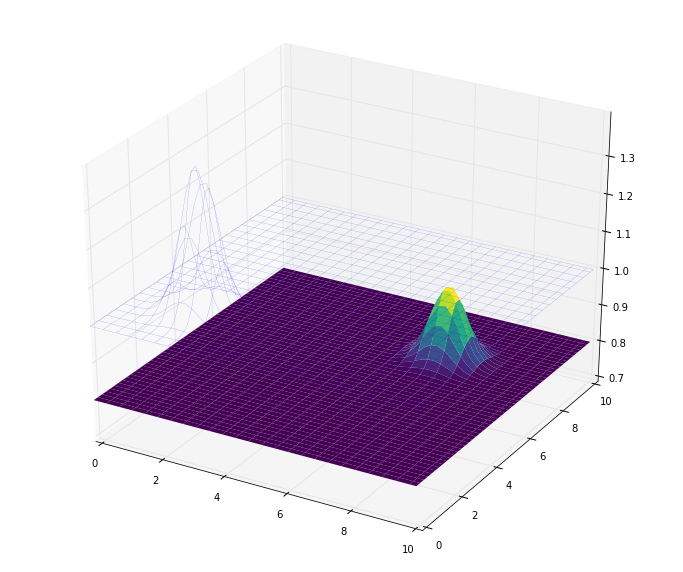

In [7]:
X, Y = np.meshgrid(U.x,U.y)

fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')

ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_zlim(0.7,1.4)

n = 1

ax.plot_surface(X[23:-23,23:-23],Y[23:-23,23:-23],U.U[0,1,25:-25,25:-25,n], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)

ax.plot_wireframe(X[23:-23,23:-23],Y[23:-23,23:-23],U.U[0,0,25:-25,25:-25,n], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)

#ax.view_init(80)
#plt.plot(x,h[0,1:-1,0],x,h[1,1:-1,0], lw=2)
plt.show()

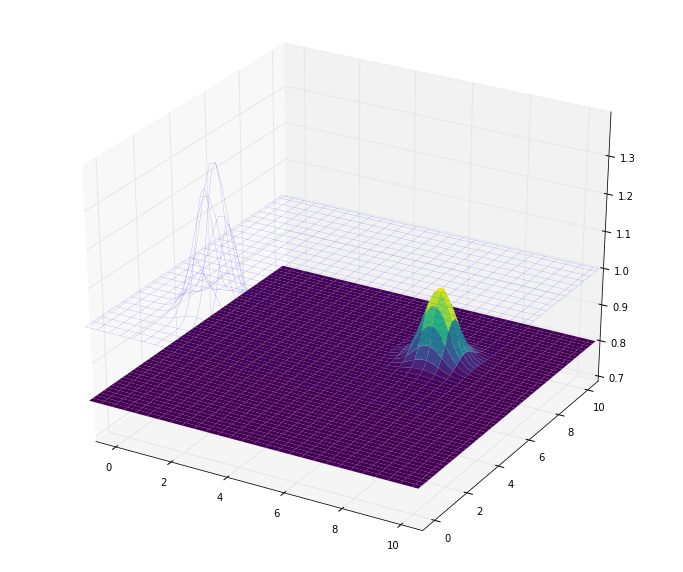

In [8]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')
#ax = plt.axes(xlim=(0,10), zlim=(0.7,1.4))
#surface_1 = ax.plot_surface([],[],[], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)[0]

#surface_2 = ax.plot_wireframe([],[],[], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)[0]
#line = ax.plot([],[], lw=2)[0]
#line2 = ax.plot([],[], lw=2)[0]

surface_1 = ax.plot_surface(X[20:-20,20:-20],Y[20:-20,20:-20],U.U[0,1,22:-22,22:-22,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)
surface_2 = ax.plot_wireframe(X[20:-20,20:-20],Y[20:-20,20:-20],U.U[0,0,22:-22,22:-22,0], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)

def init():
    surface_1 = ax.plot_surface(X[20:-20,20:-20],Y[20:-20,20:-20],U.U[0,1,22:-22,22:-22,0], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)
    surface_2 = ax.plot_wireframe(X[20:-20,20:-20],Y[20:-20,20:-20],U.U[0,0,22:-22,22:-22,0], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)


def animate(i):
    ax.clear()
    ax.set_xlim(-0.5,10.5)
    ax.set_ylim(-0.5,10.5)
    ax.set_zlim(0.7,1.4)
    ax.plot_surface(X[20:-20,20:-20],Y[20:-20,20:-20],U.U[0,1,22:-22,22:-22,i], rstride=1, cstride=2, lw=0, cmap=cm.viridis, antialiased=True)
    ax.plot_wireframe(X[20:-20,20:-20],Y[20:-20,20:-20],U.U[0,0,22:-22,22:-22,i], rstride=2, cstride=2, lw=0.1, cmap=cm.viridis, antialiased=True)
    #ax.view_init(80)
    
anim = animation.FuncAnimation(fig, animate, frames=200, interval=80)#, init_func=init)

In [9]:
HTML(anim.to_html5_video())